# Final Project
## Michele Zanotti
## Study of two datasets

In this notebook i will study two datasets:
- BTC-USD Closing prices
- Alchool sales

The first one is focused on applying ARIMA model and on trying to predict a stationary series. The second model is focused on the study of a dataset with seasonality.

## Import

In [1]:
import pandas as pd
from pandas import Grouper
from datetime import datetime
import darts 
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller, Mapper, InvertibleMapper
from darts.utils.utils import ModelMode
from darts.models import (FFT,ExponentialSmoothing, NaiveSeasonal)
from darts.metrics import (mae,mape, mase, rmse,mse)
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.layers import Bidirectional
import itertools
import warnings

In [2]:
%config Completer.use_jedi = False
warnings.filterwarnings('ignore')

# First dataset analysis

Here i load the first dataset which is about BTC-USD stock prices, as you can see i load it twice, that's because i need to use it with two different libraries. One of this libraries uses not parsed dates. 

In [3]:
df = pd.read_csv('D:\\UNIVERSITÁ\\TIME SERIES AND FORECASTING\\Final project\\BTC-USD.csv')
df2 = pd.read_csv('D:\\UNIVERSITÁ\\TIME SERIES AND FORECASTING\\Final project\\BTC-USD.csv', parse_dates= True)

Taking a look at the dataset to see how columns are organized

In [4]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-09,18320.884766,18626.292969,17935.546875,18553.916016,18553.916016,34420373071
1,2020-12-10,18553.298828,18553.298828,17957.064453,18264.992188,18264.992188,25547132265
2,2020-12-11,18263.929688,18268.453125,17619.533203,18058.904297,18058.904297,27919640985
3,2020-12-12,18051.320313,18919.550781,18046.041016,18803.656250,18803.656250,21752580802
4,2020-12-13,18806.765625,19381.535156,18734.332031,19142.382813,19142.382813,25450468637


Using the first dataset imported (df) to generate a TimeSeries object of the Darts library. Than keeping only the "Close" Column (df_close). Of the second dataset imported i keep only the columns "Close" and "Date" Columns (df_close2).

In [5]:
df1 = darts.timeseries.TimeSeries.from_dataframe(df, 'Date', ['Open', 'High', 'Low', 'Close', 'Adj Close','Volume'], fill_missing_dates=True, freq='D')
df_close = df1['Close'] 
df_close2 = df2[['Date', 'Close']]

Plotting the graph to see how the closing price of BTC-USD looks like.

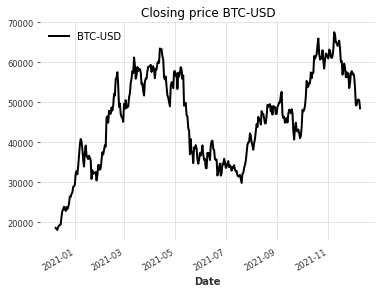

In [6]:
df_close.plot(label = 'BTC-USD')
plt.title('Closing price BTC-USD')
plt.show()

Plotting the ACF of df_close with a maximum lag of 1 year to see if there is any seasonality in this dataset.
As we ca see the ACF is sinusoidal and is decaying slowly to zero. This suggest an underlying sinusoidal model. From this graph we can say that there is a trend but not a seasonality.

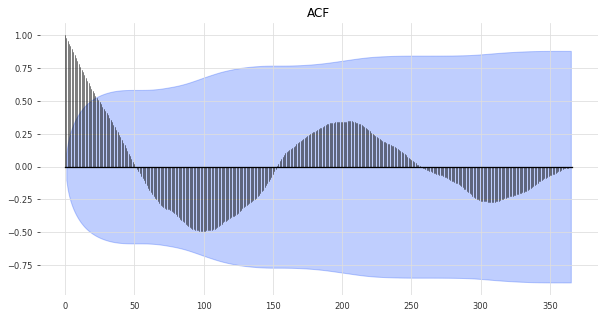

In [7]:
darts.utils.statistics.plot_acf(df_close, max_lag = 365, alpha = 0.05)
plt.title('ACF')
plt.show()

To verify my assumption (that data has only trend) i decompose this series into trend and seasonality. As we can see from graphs below all the series in in the trend part.

In [8]:
decompose = darts.utils.statistics.extract_trend_and_seasonality(df_close, freq= 1)

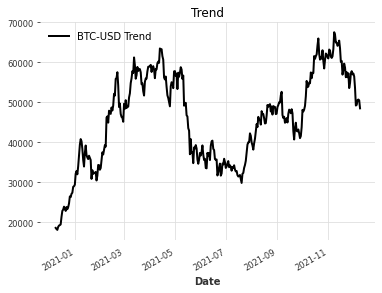

In [9]:
decompose[0].plot(label = 'BTC-USD Trend')
plt.title('Trend')
plt.show()

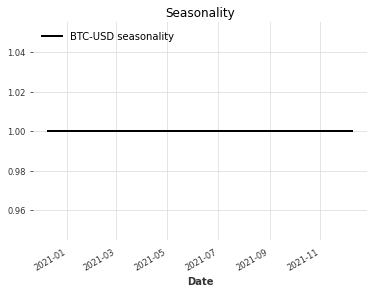

In [10]:
decompose[1].plot(label = 'BTC-USD seasonality')
plt.title('Seasonality')
plt.legend(loc = 'upper left')
plt.show()

If we subtract the trend and the seasonality from the series we obtain the residuals, in the graphs below we can see a quick analysis of the residuals. As we can see this component of the series is normally distributed, this suggest that the signal is white noise, this assumption is supported also by the ACF plot. 

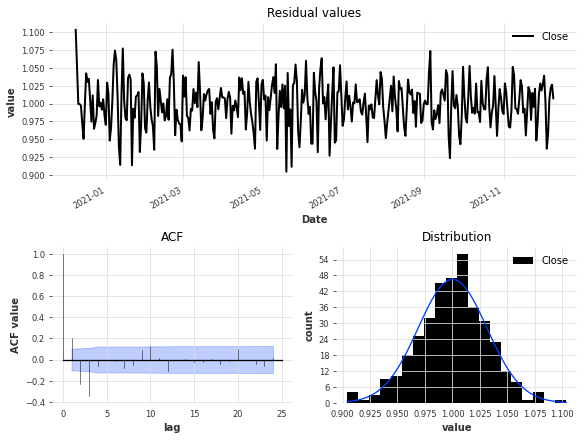

In [11]:
no_seas = darts.utils.statistics.remove_seasonality(df_close)
no_trend = darts.utils.statistics.remove_trend(no_seas)
darts.utils.statistics.plot_residuals_analysis(no_trend)
plt.show()

# Forecasting

In this section i will apply some models to forecast this series.
- Harmonic forecast
- ARIMA model
- LSTM Neural network

## Splitting in training and testing

Here i split the dataset into training and testing part, i have choosen to do 90% of training and 10% of testing since this are daily closing price and the 10% of the dataset is still a month of prediction.

In [12]:
train, val = df_close.split_after(split_point = 0.9)
train2 = df_close2[0:len(train)]
val2 = df_close2[len(train):]

Plotting the training and the validation datasets.

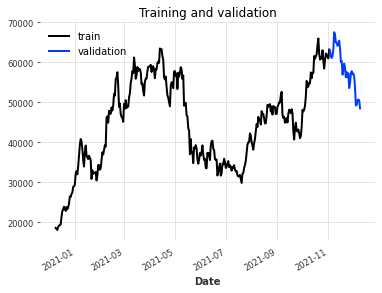

In [13]:
train.plot(label='train')
val.plot(label='validation')
plt.title('Training and validation')
plt.show()

## Harmonic Forecasting

The first model i'm using is the harmonic forecasting. Starting by building the model, i have choosen a polynomial trend, and i decided to keep the 200 most important frequencies.

In [14]:
model = FFT(trend='poly', trend_poly_degree = 5,nr_freqs_to_keep=200)
model.fit(train)
pred_val = model.predict(len(val))

Now we can see how the model is performing. From the Root mean square percentage error (RMSPE) and the Mean absolute error (MAE) we can have two values to compare the models used. As we can see from the graph predicted values are shifted with respect to the original values. Maybe this is due to a not perfect fitting of the trend.

RMSPE:  24.806461913435644
MAE:  13520.37793786578


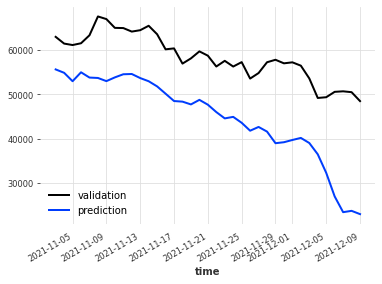

In [15]:
val.plot(label='validation')
pred_val.plot(label='prediction')
plt.legend(loc = 'lower left')
print("RMSPE: ", darts.metrics.metrics.coefficient_of_variation(actual_series=val, pred_series=pred_val))
print("MAE: ", darts.metrics.metrics.mae(actual_series=val, pred_series=pred_val) )

## ARIMA

To apply ARIMA model we need a stationary time series, the series we are currently using has a trend but not seasonality. In order to use ARIMA we have to subtract that trend or we have to differenciate the time series. I will use the Dickey-Fuller test in order to choose how many times to differenciate my time series. Let's start plotting the training and validation datasets. 

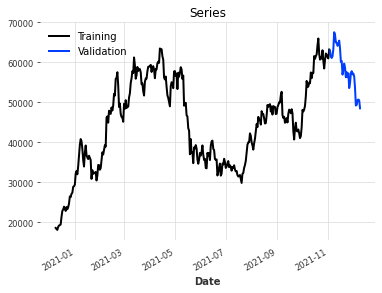

In [16]:
train.plot(label = 'Training')
val.plot(label = 'Validation')
plt.title('Series')
plt.show()

With this code i'm applying the Dickey-Fuller test to understand how many times i have to differenciate my data to obtain a stationary series. Than i plot the ACF and the PACF for 1 differencing. As we can see from the printed p-value 1 differencing is enough to make the series stationary.

ADF Statistics: -1.9665709002418548
p-value: 0.30142013688169944
ADF Statistics for 1 differencing: -19.087502404778252
p-value for 1 differencing: 0.0


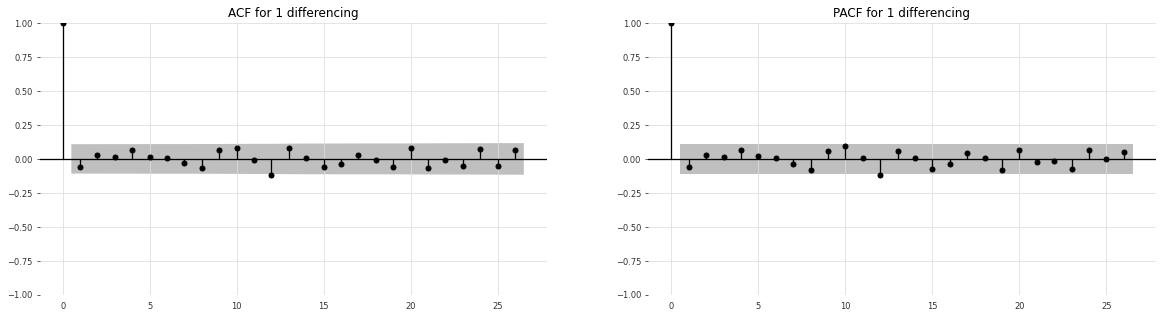

In [17]:
result = adfuller(train2['Close'])
print(f"ADF Statistics: {result[0]}")
print(f"p-value: {result[1]}")
diff = train2['Close'].diff().dropna()
result2 = adfuller(diff)
print(f"ADF Statistics for 1 differencing: {result2[0]}")
print(f"p-value for 1 differencing: {result2[1]}")
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
plot_acf(diff, ax = ax1)
ax1.set_title('ACF for 1 differencing')
plot_pacf(diff, ax = ax2, method='ywm')
ax2.set_title('PACF for 1 differencing')
plt.show()

Now we have to estimate the p, d, and q values of the arima model.
- We know that we have to differenciate only 1 time, so d = 1
- From the ACF we can obtain the value for q where the first peak cross the confidence interval, so q = 12
- From the PACF we can obtain the value for p which is taken where the PACF drops to zero, so p = 2.

In the next lines i define the model and train it.

In [18]:
model = ARIMA(train2['Close'], order = (2,1,12))
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  329
Model:                ARIMA(2, 1, 12)   Log Likelihood               -2927.892
Date:                Thu, 16 Dec 2021   AIC                           5885.785
Time:                        18:42:08   BIC                           5942.680
Sample:                             0   HQIC                          5908.485
                                - 329                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5556      0.030    -18.813      0.000      -0.613      -0.498
ar.L2         -0.9681      0.028    -34.372      0.000      -1.023      -0.913
ma.L1          0.5177      0.067      7.755      0.0

Below i plot the resudual diagnostic, as we can see residuals arenormally distributed and their ACF tell us there is no seasonality, we can assume they are withe noise.

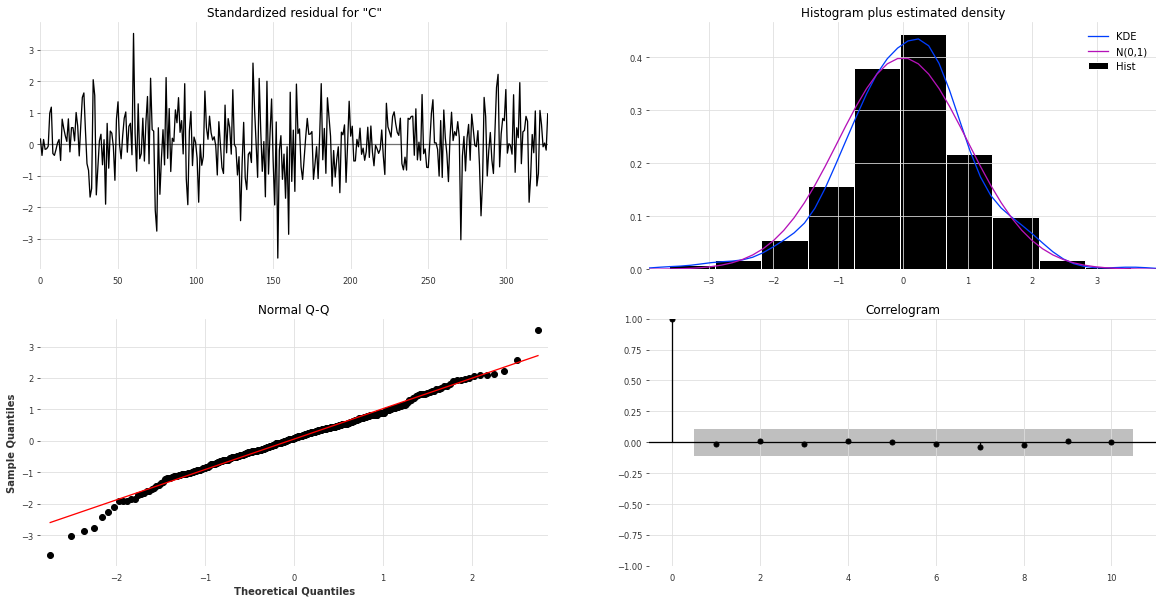

In [19]:
fig = result.plot_diagnostics()
fig.set_size_inches(20, 10)
plt.show()

Below i have plotted the training dataset along with the fitted forecasting, as we cas see from the graph they fit well.

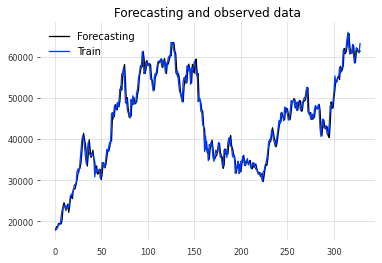

In [20]:
plt.plot(result.predict()[1:], label = 'Forecasting')
plt.plot(train2['Close'][1:], label = 'Train')
plt.legend()
plt.title('Forecasting and observed data')
plt.show()

In the next few lines i use the created model to forecast some data, than i create confidence intervals.

In [21]:
fc = result.get_forecast(len(val2))
yhat = pd.Series(fc.predicted_mean)
yhat_conf_int = fc.conf_int(alpha=0.05)

In [22]:
lower = pd.Series(yhat_conf_int['lower Close'])
upper = pd.Series(yhat_conf_int['upper Close'])

Here i display the graph containing the forecasted data, the validation data, and the 95% confidence interval. As we can see all the validation set lies within the connfidence interval. We have predicted 37 days but as we can see from the graph the model fits well only in the first 10 days, this is what i was expecting sice the data is highly volatile.

From the RMSPE and the MAE we can see that this model performs better than the Harmonic forecasting since both indicators are lower. 

RMSPE:  1.145614761212777
MAE:  5833.326211233967


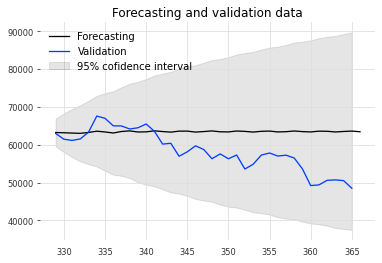

In [23]:
print("RMSPE: ", statsmodels.tools.eval_measures.rmspe(yhat, val2['Close']))
print("MAE: ", statsmodels.tools.eval_measures.meanabs(yhat, val2['Close']))
plt.plot(result.predict(start=329, end=366), label = 'Forecasting')
plt.plot(val2['Close'], label = 'Validation')
plt.fill_between(lower.index, lower, upper, color = 'k', alpha = 0.1, label = '95% cofidence interval')
plt.legend(loc = 'upper left')
plt.title('Forecasting and validation data')
plt.show()

## Let's do a Forecast with arima model

Now i don't divide the dataset in training and testing, i will use the whole dataset as training dataset and try to predict the future without knowing what's the validation dataset.

In [24]:
model_forecast = ARIMA(df_close2['Close'], order = (2,1,12))
result_forecast = model_forecast.fit()
print(result_forecast.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  366
Model:                ARIMA(2, 1, 12)   Log Likelihood               -3259.595
Date:                Thu, 16 Dec 2021   AIC                           6549.190
Time:                        18:42:25   BIC                           6607.689
Sample:                             0   HQIC                          6572.438
                                - 366                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5663      0.023    -24.368      0.000      -0.612      -0.521
ar.L2         -0.9780      0.023    -42.833      0.000      -1.023      -0.933
ma.L1          0.5315      0.061      8.657      0.0

In [25]:
fc_forecast = result_forecast.get_forecast(len(val2))
yhat_forecast = pd.Series(fc_forecast.predicted_mean)
yhat_conf_int_forecast = fc_forecast.conf_int(alpha=0.05)
lower_forecast = pd.Series(yhat_conf_int_forecast['lower Close'])
upper_forecast = pd.Series(yhat_conf_int_forecast['upper Close'])

This is the forecast predicted by the arima model with the 95% confidence interval

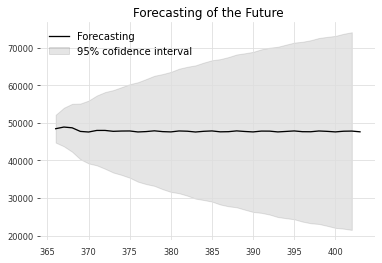

In [26]:
plt.plot(result_forecast.predict(start=366, end=403), label = 'Forecasting')
plt.fill_between(lower_forecast.index, lower_forecast, upper_forecast, color = 'k', alpha = 0.1, label = '95% cofidence interval')
plt.legend(loc = 'upper left')
plt.title('Forecasting of the Future')
plt.show()

This is the forecasted data with respect to the rest of the data, as we can see the error bands are huge with respect to the historical data.

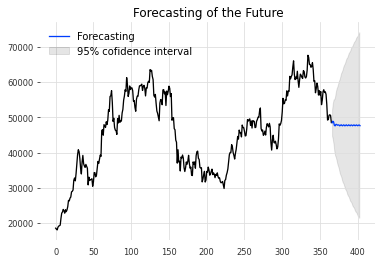

In [27]:
plt.plot(df_close2['Close'])
plt.plot(result_forecast.predict(start=366, end=403), label = 'Forecasting')
plt.fill_between(lower_forecast.index, lower_forecast, upper_forecast, color = 'k', alpha = 0.1, label = '95% cofidence interval')
plt.legend(loc = 'upper left')
plt.title('Forecasting of the Future')
plt.show()

# The one more thing: Recurrent LSTM Neural Network 

Even if we haven't seen this model in class i was courious to try it on real data to see performances. It was quite diffucult to implement but the results were satisfactory.

Let's start creating the training and the validation dataset and rescaling both so that every value have the same weight in the neural network. Since tesnorflow wants an additional dimension in our data we reshape the dataframe adding one dimension.

In [28]:
df = df['Close'].values
df = df.reshape(-1, 1)
dataset_train = np.array(df[:int(df.shape[0]*0.8)])
dataset_test = np.array(df[int(df.shape[0]*0.8):])
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)
dataset_test = scaler.transform(dataset_test)

here i define a funcion which creates two features x and y, x will contain last 50 prices and y will contain the next price (51th for example). So y will be the dataset to compare with the prediction.

In [29]:
def build_df(df):
    x = []
    y = []
    for i in range(50, df.shape[0]):
        x.append(df[i-50:i, 0])
        y.append(df[i, 0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In next lines i am dividing the train dataset and the test dataset into x and y component

In [30]:
x_train, y_train = build_df(dataset_train)
x_test, y_test = build_df(dataset_test)

Now since i want to use LSTM i have to reshape the data into a 3D array, so i will add a fictitious dimension.

In [31]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Here i build the model using 4 LSTM layers with a dropout of 0.2 (it drops 20% of the layer), and than an output layer of 1 neurnon which will give my prediction.

In [32]:
model = Sequential()
model.add(LSTM(units=96, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=96))
model.add(Dropout(0.2))
model.add(Dense(units=1))

Since now our feature has a dimension of 2 we have to reshape it into a 3D array again.

In [33]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Finally compiling the model and fitting it to my data. As we can see the loss funcion is decrising well, that means we are doing great in fitting the model to the training dataset.

In [36]:
model.compile(loss='mean_squared_error', optimizer='adam')
result2 = model.fit(x_train, y_train, epochs=50, batch_size=10)

Epoch 1/50
25/25 [==============================] - 6s 31ms/step - loss: 0.0074
Epoch 2/50
25/25 [==============================] - 1s 32ms/step - loss: 0.0068: 0s - loss: 
Epoch 3/50
25/25 [==============================] - 1s 31ms/step - loss: 0.0043
Epoch 4/50
25/25 [==============================] - 1s 32ms/step - loss: 0.0056: 0s - loss: 0.005 - ETA: 0s - loss: 
Epoch 5/50
25/25 [==============================] - 1s 32ms/step - loss: 0.0048
Epoch 6/50
25/25 [==============================] - 1s 32ms/step - loss: 0.0048
Epoch 7/50
25/25 [==============================] - 1s 32ms/step - loss: 0.0041: 0s - loss: 
Epoch 8/50
25/25 [==============================] - 1s 31ms/step - loss: 0.0069
Epoch 9/50
25/25 [==============================] - 1s 31ms/step - loss: 0.0049
Epoch 10/50
25/25 [==============================] - 1s 32ms/step - loss: 0.0041
Epoch 11/50
25/25 [==============================] - 1s 32ms/step - loss: 0.0043
Epoch 12/50
25/25 [==============================] - 1s

Here i plot the graph containing original data, forecasted data and the 95%confidence interval. As we can see from the graph the model fits well the validation dataset, and the validation dataset is always within the confidence intervals.

From RMSPE and MAE we can see that this is the best model implemented so far in this work.

RMSPE:  0.35157685656249443
MAE:  1579.3173828333338


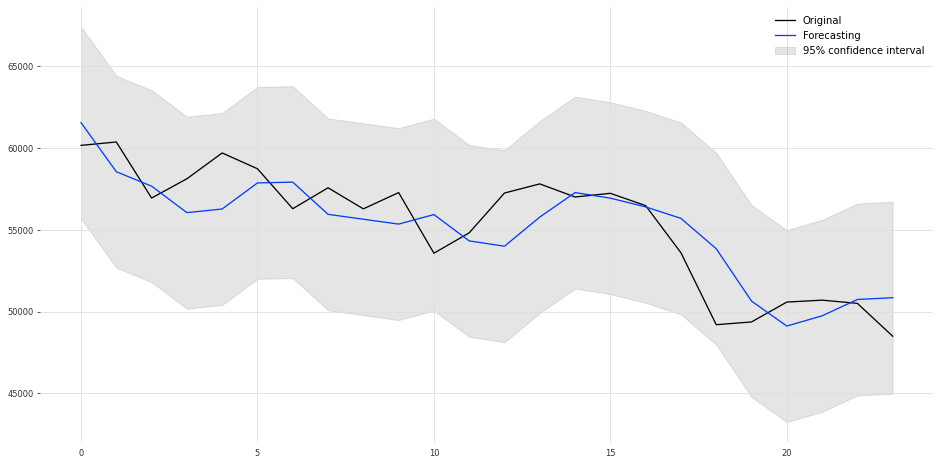

In [37]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))
std95 = predictions[:,0].std()*1.96
upper_lim = predictions[:,0] + std95
lower_lim = predictions[:,0] - std95
index = list(range(24))

print("RMSPE: ", statsmodels.tools.eval_measures.rmspe(predictions[:,0], y_test_scaled[:,0]))
print("MAE: ", statsmodels.tools.eval_measures.meanabs(predictions[:,0], y_test_scaled[:,0]))
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(y_test_scaled, label='Original')
plt.plot(predictions, label='Forecasting')
plt.fill_between(index, lower_lim, upper_lim, color = 'k', alpha = 0.1, label='95% confidence interval')
plt.legend()
plt.show()

# Second Dataset analysis

Here i load the second dataset about monthly sales of alcohol from 1964 to 1972. I also take a look at the head of the dataset to see how columns are organized.

In [38]:
df_al = pd.read_csv('D:\\UNIVERSITÁ\\TIME SERIES AND FORECASTING\\Final project\\Alchool_sales.csv')
df_al.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


Converting the dataset into a Timeseries object of the darts package and call it df_al1. Than replacing the index of the df_al dataset with the date.

In [39]:
df_al['Month'] = pd.to_datetime(df_al['Month'])
df_al1 = darts.timeseries.TimeSeries.from_dataframe(df_al, 'Month', 'Sales', fill_missing_dates=True, freq='MS')
df_al.index = pd.to_datetime(df_al['Month'])
df_al.drop(columns='Month',inplace=True)

Let's plot the data in order to see how it looks like. As we can see there is a strong seasonality.

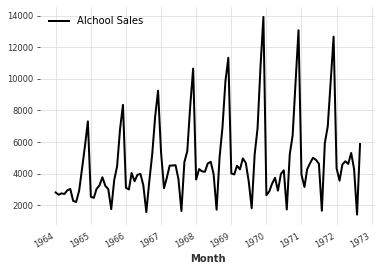

In [40]:
df_al1.plot(label = 'Alchool Sales')
plt.legend(loc = 'upper left')
plt.show()

To better undeline this seasonality i make a seasonal plot where the data of every year is plotted by month. 

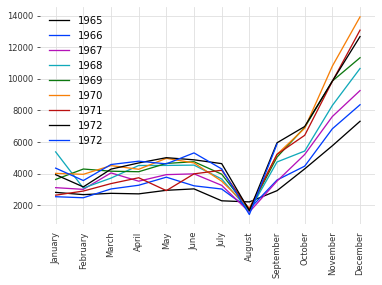

In [41]:
groups = df_al.groupby(Grouper(freq='MS'))
a = []
b = []
c = []
d = []
y = []
for name, group in groups:
    if name.strftime("%B") == 'January':
        if len(a) > 0 and len(b) > 0:
            c.append(a)
            d.append(b)
            y.append(name.strftime("%Y"))
        a = []
        b = []
        a.append(name.strftime("%B"))
        b.append(group['Sales'].values[0])
    else:
        a.append(name.strftime("%B"))
        b.append(group['Sales'].values[0])
c.append(a)
d.append(b)
y.append(name.strftime("%Y"))

for i in range (0, len(a)):
    plt.plot(c[i], d[i], label = y[i])
    plt.xticks(rotation=90)
    plt.legend()

Lets plot an acf in order to see what's the exact seasonality. As we can see from the ACF plot the strongest seasonality is for 12 month (every year) and in the graph is underlined by the red bar crossing the blue confidence interval.

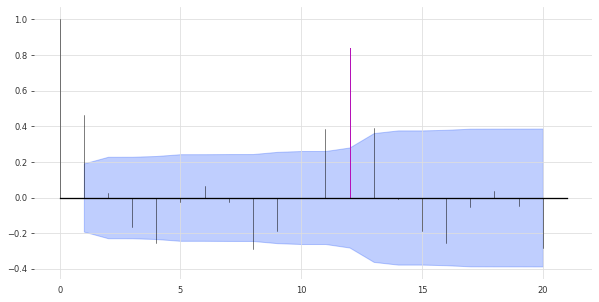

In [42]:
darts.utils.statistics.plot_acf(df_al1, max_lag = 20, alpha = 0.05, m = 12)

Now let's decompose the signal into trend, seasonal, and residual components. As we can see there are both a trend and a seasonality.

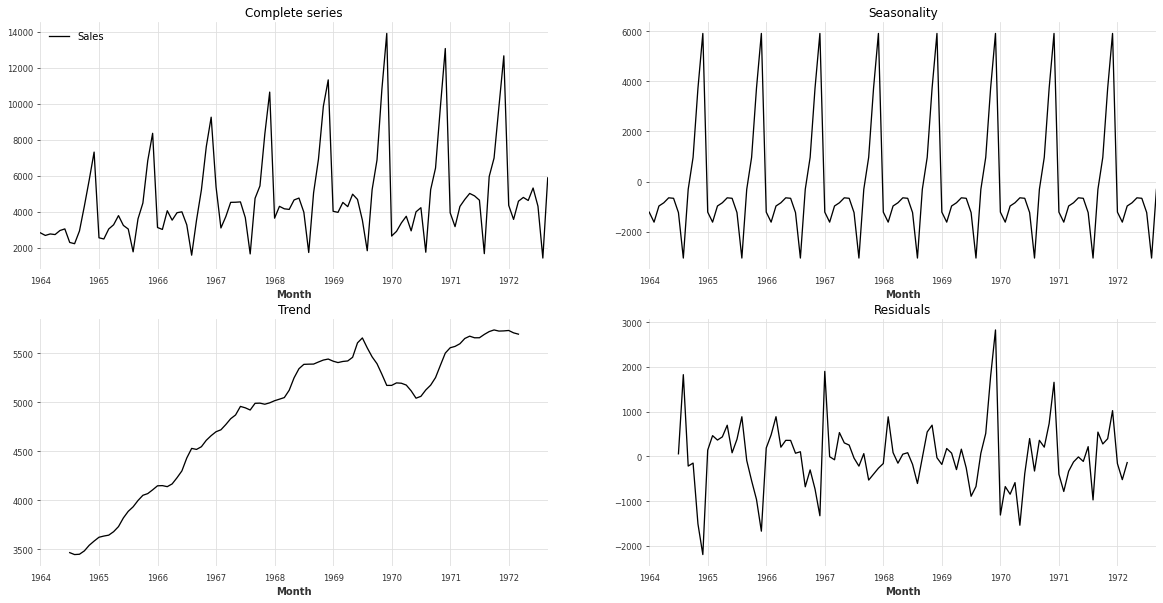

In [43]:
decompose = seasonal_decompose(df_al, model="additive")

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2,2, figsize=(20, 10))
df_al.plot(ax = ax1)
ax1.set_title('Complete series')
ax1.legend(loc = 'upper left')
decompose.seasonal.plot(ax = ax2)
ax2.set_title('Seasonality')
decompose.trend.plot(ax = ax3)
ax3.set_title('Trend')
decompose.resid.plot(ax = ax4)
ax4.set_title('Residuals')
plt.show()

Let's study the residuals. As we can see also in the residuals there is a seasonality and they are not normally distributed.

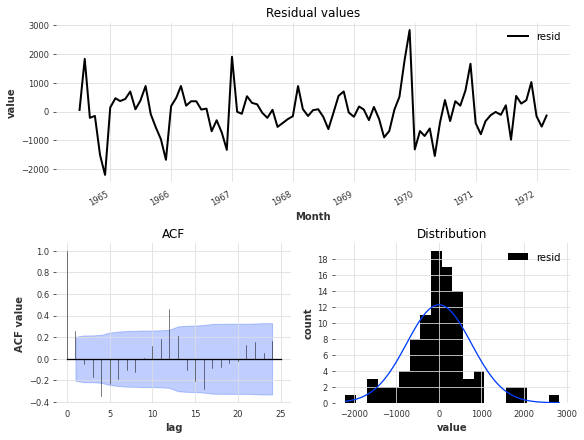

In [44]:
residuals = decompose.resid.dropna()
residuals = pd.DataFrame(residuals)
a = residuals['resid'].values
b = residuals['resid'].index
data = {'Month':b,
        'resid': a}
data = pd.DataFrame(data)
data = darts.timeseries.TimeSeries.from_dataframe(data, 'Month', 'resid',fill_missing_dates=True, freq='MS')
darts.utils.statistics.plot_residuals_analysis(data)
plt.show()

# Forecasting

For this dataset i will apply 3 methods to forecast:
- Seasonal naïve
- Harmonic Forecasting
- SARIMA

## Splitting in training and validation sets

Let's start choosing the validation and training datasets, i have choosed to use 80% for training and 20% for validation.

In [45]:
train_al1, val_al1 = df_al1.split_after(split_point = 0.8)
train_al = df_al[0:len(train_al1)]
val_al = df_al[len(train_al1):]

Now i plot the training and the validation dataset

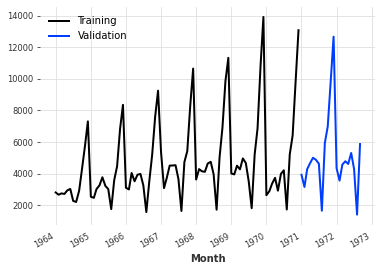

In [46]:
train_al1.plot(label = 'Training')
val_al1.plot(label = 'Validation')
plt.legend(loc = 'upper left')
plt.show()

## Seasonal Naïve

In this line i build the seasonal naive model, using the information obtained from the ACF i set the seasonality of this series to 12 months, obtaining a very good result even for this very simple model. The RMSPE and the MAE of this model will be used as a standard for a comparison with other models implemented in this study.

RMSPE:  19.65319351001559
MAE:  823.1428571428571


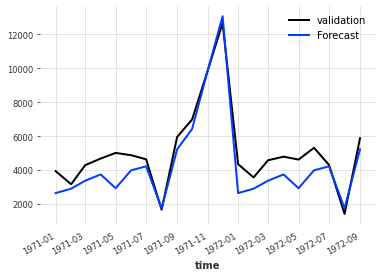

In [47]:
seasonal_model = NaiveSeasonal(K=12)
seasonal_model.fit(train_al1)
seasonal_forecast = seasonal_model.predict(len(val_al1))

print("RMSPE: ", darts.metrics.metrics.coefficient_of_variation(actual_series=val_al1, pred_series=seasonal_forecast))
print("MAE: ", darts.metrics.metrics.mae(actual_series=val_al1, pred_series=seasonal_forecast) )
val_al1.plot(label='validation')
seasonal_forecast.plot(label='Forecast')
plt.legend()
plt.show()

## Exponential Smoothing

Let's build the exponential smoothing model for this dataset. I have used additive trend and seasonality, and as the ACF suggested i use a seasoal period of 12 months.

In [48]:
model = ExponentialSmoothing(trend= ModelMode.ADDITIVE, seasonal = ModelMode.ADDITIVE, seasonal_periods = 12)
model.fit(train_al1)
ets_pred = model.predict(len(val_al1))

Now let's plot the results, as we can see from the RMSPE and from the MAE this model performs better than the naïve seasonal.

RMSPE:  15.071345268307212
MAE:  656.4129942759047


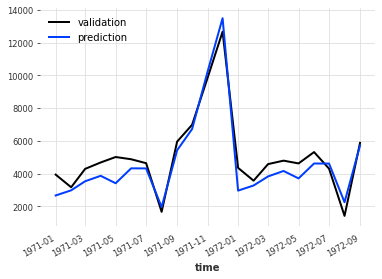

In [49]:
val_al1.plot(label='validation')
ets_pred.plot(label='prediction')
plt.legend(loc = 'upper left')
print("RMSPE: ", darts.metrics.metrics.coefficient_of_variation(actual_series=val_al1, pred_series=ets_pred))
print("MAE: ", darts.metrics.metrics.mae(actual_series=val_al1, pred_series=ets_pred))

## SARIMA

In the end let's build a Seasonal arima model, firstly we have to check how many times we have to differenciate in order to obtain a stationary series. I will use the Dickey-Fuller test. From the Dickey-Fuller test we can see that 1 differencing is enough to make the series stationary.

ADF Statistics: -2.295554260552979
p-value: 0.1734058202954757
ADF Statistics for 1 differencing: -21.725876749107623
p-value for 1 differencing: 0.0


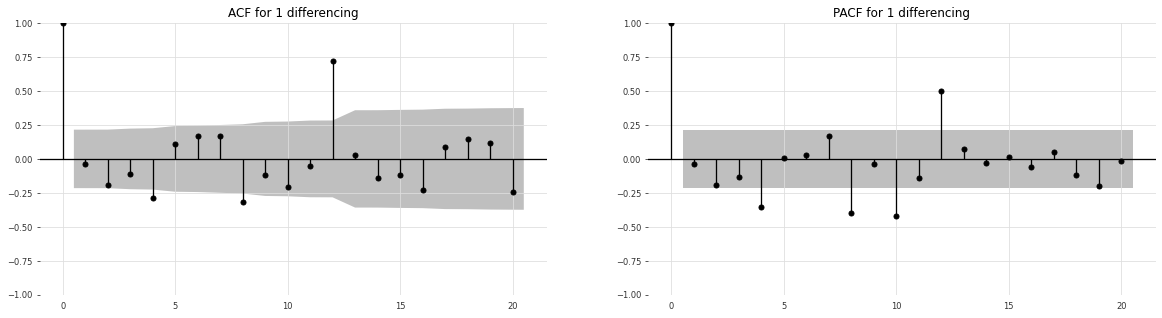

In [50]:
result = adfuller(train_al['Sales'].values)
print(f"ADF Statistics: {result[0]}")
print(f"p-value: {result[1]}")
diff = train_al['Sales'].diff().dropna()
result2 = adfuller(diff.values)
print(f"ADF Statistics for 1 differencing: {result2[0]}")
print(f"p-value for 1 differencing: {result2[1]}")

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(20, 5))
plot_acf(diff, ax = ax1)
ax1.set_title('ACF for 1 differencing')
plot_pacf(diff, ax = ax2, method='ywm')
ax2.set_title('PACF for 1 differencing')
plt.show()

Building the model, this time i try to optimize the choice of p, d and q with respect to the RMSPE, so let's build a function to do this work.

In [51]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
best_rmspe = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

Here there's the function to try different combination of pdq and save te one that minimizes the root mean square percentage error. 

In [52]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = SARIMAX(train_al['Sales'],order=param,seasonal_order=param_seasonal, trend = 't', freq = 'MS',  enforce_stationarity=True)
            results = temp_model.fit()
            best_prediction = results.predict(start=84,end=104,dynamic=True)
            prova = statsmodels.tools.eval_measures.rmspe(best_prediction, val_al.values[:,0])

            if prova < best_rmspe:
                best_rmspe = prova
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            # print("Unexpected error:", sys.exc_info()[0])
            continue

As we can see the function suggested for order (1,0,0) and for seasonal (1,0,1,12). So it has suggested no differentiation which has left me dissappointed, since i was expecting to make 1 differentiation at least, as suggested by the Dickey-Fuller test. But as we can see from the prediction and from the RMSPE and from the MAE this cofiguration gives the best result. 

In [54]:
print("Best SARIMAX {} x {} model".format(best_pdq, best_seasonal_pdq))

Best SARIMAX (1, 0, 0) x (1, 0, 1, 12) model


In [56]:
best_model = SARIMAX(train_al['Sales'],order = (1,0,0),seasonal_order=(1,0,1,12), trend = 't', freq = 'MS')
best_results = best_model.fit()

As we cas see this model is the one that best fits the validation dataset.

RMSPE:  1.6605841175895135
MAE:  467.1714305714755


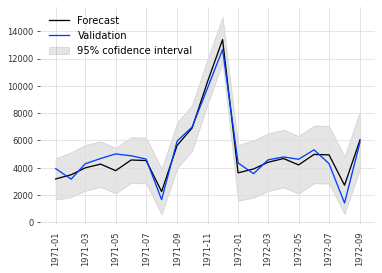

In [60]:
best_prediction = best_results.predict(start=84,end=104,dynamic=True)
print("RMSPE: ", statsmodels.tools.eval_measures.rmspe(best_prediction[:len(val_al)], val_al.values[:,0]))
print("MAE: ", statsmodels.tools.eval_measures.meanabs(best_prediction[:len(val_al)], val_al.values[:,0]))
best_fc = best_results.get_forecast(len(val_al))
best_yhat = pd.Series(best_fc.predicted_mean)
best_yhat_conf_int = best_fc.conf_int(alpha=0.05)
best_lower = best_yhat_conf_int['lower Sales']
best_upper = best_yhat_conf_int['upper Sales']
plt.fill_between(best_lower.index, best_lower, best_upper, color = 'k', alpha = 0.1, label = '95% cofidence interval')
plt.plot(best_prediction, label = 'Forecast')
plt.plot(val_al, label = 'Validation')
plt.legend(loc = 'upper left')
plt.xticks(rotation=90)
plt.show()

## Let's do a forecast with SARIMA model

Now i will try to predict some future data using the model developed.

In [58]:
best_model_forecasted = SARIMAX(df_al['Sales'],order = (1,0,0),seasonal_order=(1,0,1,12), trend = 't', freq = 'MS')
best_results_forecasted = best_model_forecasted.fit()

Here we can see the prediction alone

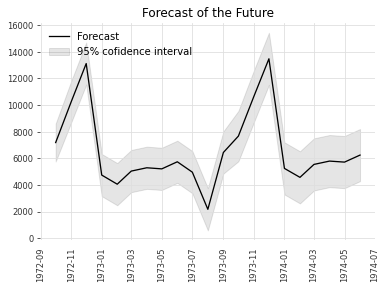

In [61]:
best_prediction_forecasted = best_results_forecasted.predict(start=105,end=125,dynamic=True)
best_fc_forecasted = best_results_forecasted.get_forecast(len(val_al))
best_yhat_forecasted = pd.Series(best_fc_forecasted.predicted_mean)
best_yhat_conf_int_forecasted = best_fc_forecasted.conf_int(alpha=0.05)
best_lower_forecasted = best_yhat_conf_int_forecasted['lower Sales']
best_upper_forecasted = best_yhat_conf_int_forecasted['upper Sales']
plt.fill_between(best_lower_forecasted.index, best_lower_forecasted, best_upper_forecasted, color = 'k', alpha = 0.1, label = '95% cofidence interval')
plt.plot(best_prediction_forecasted, label = 'Forecast')
plt.legend(loc = 'upper left')
plt.title('Forecast of the Future')
plt.xticks(rotation=90)
plt.show()

Here we can see the prediction with respect to the rest of the dataset. As we can see with this dataset the prediction is quite relyable since the confidence interval is small with respect the rest of the dataset.

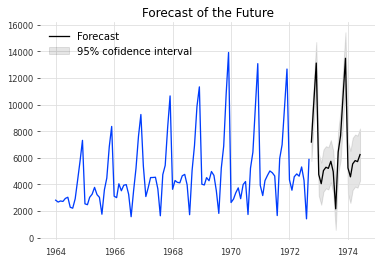

In [62]:
best_prediction_forecasted = best_results_forecasted.predict(start=105,end=125,dynamic=True)
best_fc_forecasted = best_results_forecasted.get_forecast(len(val_al))
best_yhat_forecasted = pd.Series(best_fc_forecasted.predicted_mean)
best_yhat_conf_int_forecasted = best_fc_forecasted.conf_int(alpha=0.05)
best_lower_forecasted = best_yhat_conf_int_forecasted['lower Sales']
best_upper_forecasted = best_yhat_conf_int_forecasted['upper Sales']
plt.fill_between(best_lower_forecasted.index, best_lower_forecasted, best_upper_forecasted, color = 'k', alpha = 0.1, label = '95% cofidence interval')
plt.plot(best_prediction_forecasted, label = 'Forecast')
plt.plot(df_al)
plt.legend(loc = 'upper left')
plt.title('Forecast of the Future')
plt.show()